In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import savetxt
from astropy.io import ascii
from astropy.time import Time
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.stats import median_absolute_deviation

from collections import deque
from bisect import insort, bisect_left
from itertools import islice

In [2]:
clip_distance, window_size = 0.1, 12
def running_median_insort(seq, window_size):
    """Contributed by Peter Otten"""
    seq = iter(seq)
    d = deque()
    s = []
    result = []
    for item in islice(seq, window_size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = window_size // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

def binner(bins, time, flux):
    means, errors = [], []
    midpoints = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    for i in range(len(bins)-1):
        binned_mask = (time < bins[i+1])*(time > bins[i])
        means.append(np.mean(flux[binned_mask]))
        errors.append(np.std(flux[binned_mask])/np.sqrt(len(flux[binned_mask])))
    return means, errors, midpoints

## Normalising it all

In [3]:
tess = ascii.read('j1407_tess_new_elenor.txt')

In [4]:
#r_flux = butcher.mag_to_flux(road['mag'])
#r_eflux = butcher.emag_to_eflux(road['mag'], road['emag'])

#r_flux = butcher.long_correct(road['HJD'], r_flux, r_eflux)
#r_time = road['HJD']


#f_sorted = sorted(r_flux)
#cdf = np.cumsum(f_sorted)/np.cumsum(f_sorted)[-1]
#lower, upper = np.interp([0.05, 0.95], cdf, f_sorted)
#print("The amplitude is ", '{0:.4f}'.format((upper-lower)/2))

#t_mask = (r_time > 58600)*(r_time < 58625)
#r_time, r_flux, r_eflux = r_time[t_mask]-57000, r_flux[t_mask], r_eflux[t_mask]

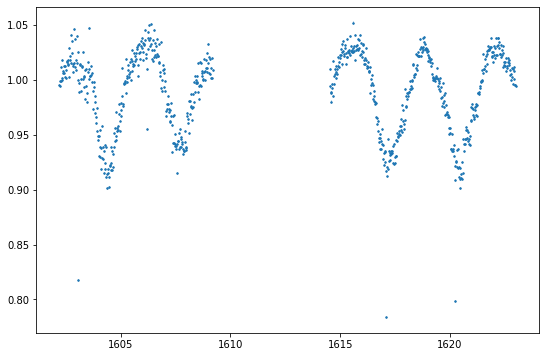

The amplitude is  0.0550


In [13]:
time = tess['col1']
flux = tess['col2']
eflux = tess['col3']



mask = (time > 1602.2)*(eflux < 1000)*(flux > 100)*(time < 1623) 

time = time[mask]
flux = flux[mask]
eflux = eflux[mask]

shaky_mask = (time > 1609.2) * (time < 1614.5) #The earth reflection happens here
time = time[~shaky_mask]
flux = flux[~shaky_mask]
eflux = eflux[~shaky_mask]



flux_norm = flux/np.median(flux)
eflux_norm = eflux/np.median(flux)


plt.errorbar(time, flux_norm, eflux_norm, fmt='.', markersize= 3, elinewidth=0.5)
figure = plt.gcf()
figure.set_size_inches(9, 6)
plt.show()

time_fu = time
flux_fu = flux_norm
eflux_fu = eflux_norm

fu_sorted = sorted(flux_fu)
cdf = np.cumsum(fu_sorted)/np.cumsum(fu_sorted)[-1]
lower, upper = np.interp([0.05, 0.95], cdf, fu_sorted)
print("The amplitude is ", '{0:.4f}'.format((upper-lower)/2))

## Median Clipping

In [14]:
#fig, ax = plt.subplots(3, sharey=True)

#ax[0].errorbar(time_fu, flux_fu, eflux_fu, fmt='.', markersize= 3, elinewidth=0.5)
#ax[0].errorbar(r_time, r_flux, r_eflux, fmt='.', markersize= 3, elinewidth=0.5)
#figure = plt.gcf()
#figure.set_size_inches(12, 9)
#ax[0].set_title("Uncorrected TESS")
#ax[0].set_ylim(0.86, 1.08)
#print("Scatter is", np.std(flux_fu))

#ax[1].errorbar(time_fu, flux_fu, eflux_fu, fmt='.', markersize= 3, elinewidth=0.5)
#ax[1].plot(time_fu, running_median_insort(flux_fu, window_size), lw = 2)
#ax[1].set_title("Running Median TESS")

median_mask = (flux_fu > running_median_insort(flux_fu, window_size)+ np.array([clip_distance]*len(flux_fu)))
time_f, flux_f, eflux_f = time_fu[~median_mask], flux_fu[~median_mask], eflux_fu[~median_mask]

#ax[2].errorbar(time_f, flux_f, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
#figure = plt.gcf()
#figure.set_size_inches(12, 15)
#ax[2].set_title("Median Clipped TESS")
#plt.savefig("TESS_initial_reduction.png")
#plt.show()
print("Scatter is", np.std(flux_f))

Scatter is 0.03744747896289413


## Ringaling

In [15]:
# find a0,a1,a2,a3,a4 that is the best fit to the plot above

def ringaling(phi,*c):
    # c is a numpy array containing an odd number of coeffieicnts
    # so that c[0] + c[1]*np.sin(phi) + c[2]*np.cos(phi) + c[3]*np.sin(2*phi) + c[4]*np.cos(2*phi) + .....
    #if (c.size%2 == 0):
    #    print('whoa! we need an odd number of coefficients in c')
    #    return 1
    c = np.array(c)
    npairs = (c.size-1)/2
    result = 0
    for i in np.arange(npairs):
        a_sin = c[((i*2)+1).astype(int)]
        a_cos = c[((i*2)+2).astype(int)]
        result = result + a_sin*np.sin(phi*(i+1)) + a_cos*np.cos(phi*(i+1))
    return result+c[0]

The highest power period is  3.200  days.
The best fit parameters are  [ 0.9856859  -0.04245532  0.02329002  0.00643448  0.00681317]
1.0257403996184933 0.9280540384214339


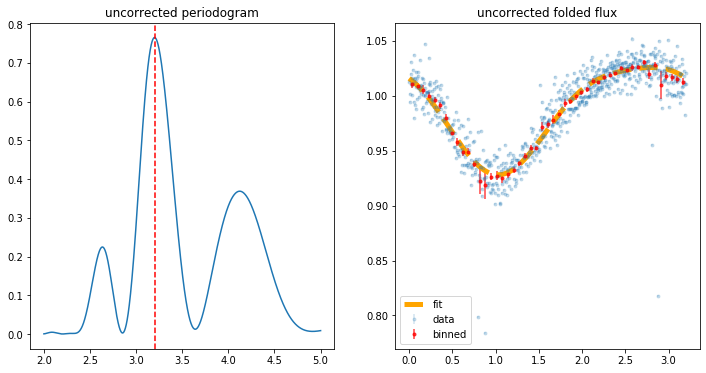

In [16]:
fig, ax = plt.subplots(1, 2)

frequencies = 1/np.linspace(2, 5, 3000)
power = LombScargle(time_f, flux_f-np.mean(flux_f), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')


ax[0].plot(1/frequencies, power)
ax[0].axvline(x = max_period, c= 'r', linestyle = '--')
ax[0].set_title('uncorrected periodogram')
power_lim = ax[0].set_ylim()

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_f)

ax[1].errorbar(time_folded, flux_f, eflux_f, fmt = '.', label = 'data', alpha = 0.2)
ax[1].errorbar(midpoints, means, errors, fmt = '.', label = 'binned', alpha = 0.75, c = 'r')
ax[1].set_title('uncorrected folded flux')

popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200
ax[1].plot(phi*max_period/(2*np.pi), ringaling(phi, *popt), linestyle = '--', c= 'orange', label= 'fit', lw =5)
ax[1].legend()

print(np.max(ringaling(phi, *popt)), np.min(ringaling(phi, *popt)))

fig = plt.gcf()
fig.set_size_inches(12, 6)
#plt.savefig("32_correction_10.png")
plt.show()

flux_32_corr = flux_f-ringaling(time_folded*2*np.pi/(max_period), *popt)

#Unbinned fit [ 0.98553516 -0.02888544  0.03155577  0.00963583 -0.00272195]
#Binned fit [ 0.98650794 -0.02922539  0.03292504  0.00910987 -0.00141807]

The highest power period is  8.330  days.
The best fit parameters are  [-0.0008093  -0.0054403   0.00635436 -0.00316363  0.00040704]


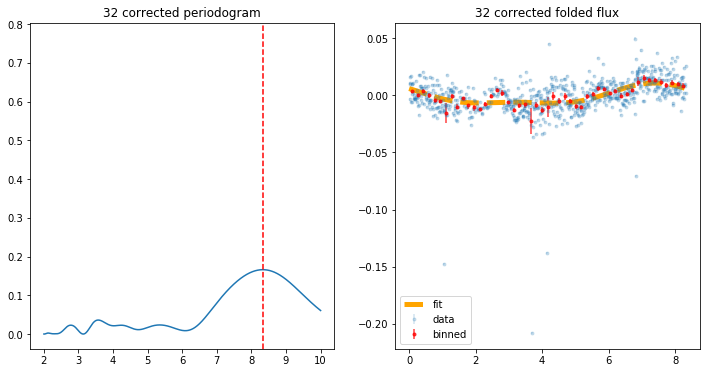

In [17]:
fig, ax = plt.subplots(1, 2)

frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_32_corr-np.mean(flux_32_corr), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')


ax[0].plot(1/frequencies, power)
ax[0].axvline(x = max_period, c= 'r', linestyle = '--')
ax[0].set_ylim(power_lim)
ax[0].set_title('32 corrected periodogram')

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_32_corr)

ax[1].errorbar(time_folded, flux_32_corr, eflux_f, fmt = '.', label = 'data', alpha = 0.2)
ax[1].errorbar(midpoints, means, errors, fmt = '.', label = 'binned', alpha = 0.75, c = 'r')
ax[1].set_title('32 corrected folded flux')

popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200
ax[1].plot(phi*max_period/(2*np.pi), ringaling(phi, *popt), linestyle = '--', c= 'orange', label= 'fit', lw =5)
ax[1].legend()

fig = plt.gcf()
fig.set_size_inches(12, 6)
#plt.savefig("3242_correction.png")
plt.show()

#Unbinned fit [ 9.99227834e-01  1.52563563e-03  9.68944419e-03 -4.21332667e-03 8.50444969e-04]
#Binned fit [ 1.00060393e+00  8.86011777e-04  9.98378584e-03 -3.15840939e-03 1.58680762e-04]

flux_32et42_corr = flux_32_corr-ringaling(time_folded*2*np.pi/(max_period), *popt)

The highest power period is  3.395  days.
The best fit parameters are  [-0.00060226 -0.00226157 -0.00350479 -0.00136681 -0.0006461 ]


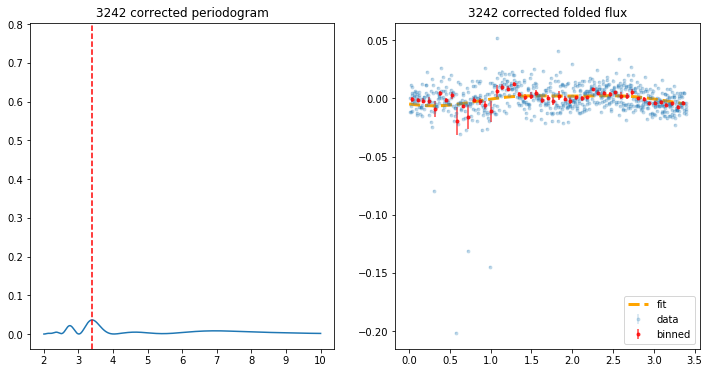

In [18]:
fig, ax = plt.subplots(1, 2)

frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_32et42_corr-np.mean(flux_32et42_corr), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')


ax[0].plot(1/frequencies, power)
ax[0].axvline(x = max_period, c= 'r', linestyle = '--')
ax[0].set_ylim(power_lim)
ax[0].set_title('3242 corrected periodogram')

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_32et42_corr)


ax[1].errorbar(time_folded, flux_32et42_corr, eflux_f, fmt = '.', label = 'data', alpha = 0.2)
ax[1].errorbar(midpoints, means, errors, fmt = '.', label = 'binned', alpha = 0.75, c = 'r')
ax[1].set_title('3242 corrected folded flux')

popt, pcov = curve_fit(ringaling, time_folded*2*np.pi/(max_period), flux_32et42_corr, sigma = eflux_f, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200
ax[1].plot(phi*max_period/(2*np.pi), ringaling(phi, *popt), linestyle = '--', c= 'orange', label= 'fit', lw =3)
ax[1].legend()

fig = plt.gcf()
fig.set_size_inches(12, 6)
#plt.savefig("3242non_correction.png")
plt.show()

Scatter is 0.03744747896289413


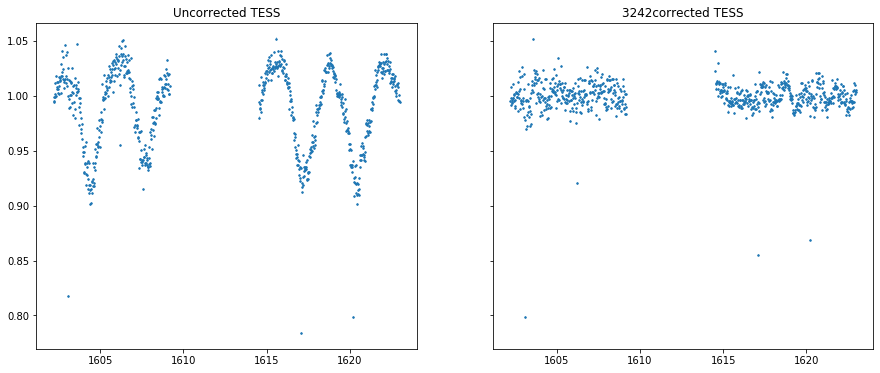

Scatter is 0.014699065054780872


In [19]:
fig, ax = plt.subplots(1, 2, sharey = True)

ax[0].errorbar(time_f, flux_f, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
figure = plt.gcf()
figure.set_size_inches(12, 9)
ax[0].set_title("Uncorrected TESS")
print("Scatter is", np.std(flux_f))

ax[1].errorbar(time_f, flux_32et42_corr+1, eflux_f, fmt='.', markersize= 3, elinewidth=0.5)
figure = plt.gcf()
figure.set_size_inches(15, 6)
ax[1].set_title("3242corrected TESS")
#plt.savefig("3242_endresult.png")
plt.show()
print("Scatter is", np.std(flux_32et42_corr))

## Saving the csv

In [12]:
tess_final = np.zeros((len(time_f), 3))
tess_final[:, 0] = time_f
tess_final[:, 1] = flux_32et42_corr+1
tess_final[:, 2] = eflux_f

C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3370: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


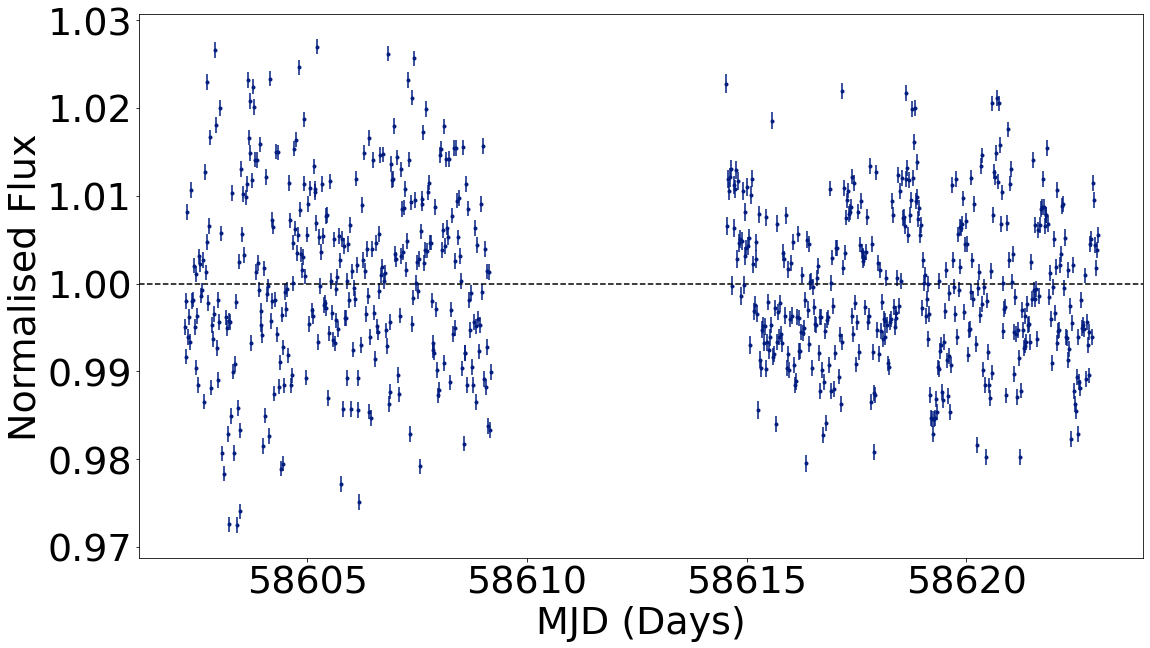

In [22]:
import matplotlib
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 38}
matplotlib.rc('font', **font)

means_1, errors_1, midpoints_1 = binner(np.linspace(np.min(time_f), np.max(time_f), 50), time_f, flux_32_corr)
means_2, errors_2, midpoints_2 = binner(np.linspace(np.min(time_f), np.max(time_f), 50), time_f, flux_32et42_corr)

scat_mask = (tess_final[:, 1] < np.mean(tess_final[:, 1]) + 2*np.std(tess_final[:, 1]))*(tess_final[:, 1] > np.mean(tess_final[:, 1]) - 2*np.std(tess_final[:, 1]))

plt.errorbar(tess_final[:, 0][scat_mask]+57000, tess_final[:, 1][scat_mask], tess_final[:, 2][scat_mask], fmt='.')
plt.axhline(y = 1.0, linestyle = '--', c='black')
plt.xlabel('MJD (Days)')
plt.ylabel("Normalised Flux")

#plt.errorbar(tess_final[:, 0], flux_32_corr+1, tess_final[:, 2], fmt='.', markersize= 3, elinewidth=0.5)

#plt.errorbar(midpoints_1, np.array(means_1)+1, errors_1, fmt='.', c='r')
#plt.errorbar(midpoints_2, np.array(means_2)+1, errors_2, fmt='.', c = 'g')

figure = plt.gcf()
figure.set_size_inches(18, 10)
#plt.savefig('TESS_New_Elenor_LC.pdf')
plt.show()

In [19]:
print(np.std(tess_final[:, 1][scat_mask]))

0.00965651737012819


In [14]:
#np.savetxt("Final_TESS_092-145_new_elenor.csv", tess_final, delimiter=',') 